# Where to invest in real estate?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Getting the data

The data for this analysis is obtained from [Zillow data](http://www.zillow.com/research/data/). Please go to the source to get the raw data. The analysis was carried out on Sept 25, 2016. This is a fun exercise and so usual disclaimers apply.

Going with the conventional wisdom that "Real estate is local", I am taking the ZHVI (Zillow house value index) and ZRI (Zillow Rent Index) for "Neighborhoods" rather than State/County/City data. Though the granularity of zip seems to be finer (having more number of rows than "Neighborhood"), as of time of this analysis, the zip level ZRI is unavailable for download from the site.

In [2]:
# Getting ZHVI
home_values = pd.read_csv('./data/Neighborhood_Zhvi_Summary_AllHomes.csv')

# Getting ZRI
rents = pd.read_csv('./data/Neighborhood_Zri_AllHomesPlusMultifamily_Summary.csv')
rents = rents[['RegionName','City','Zri','MoM','QoQ','YoY']]
old_names = ['MoM','QoQ','YoY']
new_names = ['rent_MoM','rent_QoQ','rent_YoY']
rents.rename(columns=dict(zip(old_names, new_names)), inplace=True)

# Joining the data
home_values_rents_raw = pd.merge(home_values, rents, how='inner', on=['RegionName','City'])

In [3]:
# Checking for rent/value ratio
home_values_rents_raw['rent_by_value'] = home_values_rents_raw['Zri']/home_values_rents_raw['Zhvi']
home_values_rents_raw.sort_values(['rent_by_value'], ascending=[False]).head()

,Date,RegionID,RegionName,State,Metro,County,City,SizeRank,Zhvi,MoM,...,PeakMonth,PeakQuarter,PeakZHVI,PctFallFromPeak,LastTimeAtCurrZHVI,Zri,rent_MoM,rent_QoQ,rent_YoY,rent_by_value
3864,2016-08-31,416693,Coppin Heights - Ash-Co-East,MD,Baltimore,Baltimore City,Baltimore,3933,38500,-0.020356,...,2011-02,2011-Q1,54500,-0.293578,NaN,1209,-0.002475,0.000000,-0.021845,0.031403
489,2016-08-31,271222,Strawberry Mansion,PA,Philadelphia,Philadelphia,Philadelphia,494,32100,0.000000,...,2010-02,2010-Q1,53900,-0.404453,2002-03,1004,0.011078,0.021363,0.015167,0.031277
1622,2016-08-31,417114,Coldstream Homestead Montebello,MD,Baltimore,Baltimore City,Baltimore,1649,42100,-0.007075,...,2010-07,2010-Q3,59800,-0.295987,2003-11,1277,-0.009310,-0.022205,-0.006998,0.030333
3074,2016-08-31,269770,Broadway East,MD,Baltimore,Baltimore City,Baltimore,3128,40600,0.025253,...,2010-08,2010-Q3,46900,-0.134328,NaN,1218,-0.004902,-0.004902,0.016694,0.030000
5627,2016-08-31,263765,Stanton,PA,Philadelphia,Philadelphia,Philadelphia,5731,36100,-0.002762,...,2009-12,2009-Q4,55900,-0.354204,2004-10,1058,0.016330,0.045455,0.090722,0.029307


Ummm.. not sure if the above are "safe" neighborhoods. So will filter for neighborhoods with median home values > 200K

## Calculating Return on investment
Ideally ROI should be calculated for each sample point (home) and then the median in a neighborhood should be considered. However since the complete data is not available, Median Rent estimate (ZRI) and Median home value (ZHVI) are considered for ROI calculation as an approximation

In [4]:
home_values_rents = home_values_rents_raw[home_values_rents_raw['Zhvi'] > 200000].copy()

# Calculating the yearly return of investment. 
# Assumptions:
# vacancy - 10% of time
# property management cost - 7% of rent after accounting for vacancy
# home insurance per annum - 0.3% of home value
# maintainence per annum - 0.2% of home value
VACANCY = 0.1
PRP_MGMT = 0.07
INSR = 0.003
MAINT = 0.002

yearly_rent = (home_values_rents['Zri']*12*(1-VACANCY-PRP_MGMT) - 
                          home_values_rents['Zhvi']*(INSR+MAINT))                          
home_values_rents['roi'] = yearly_rent*100/home_values_rents['Zhvi']

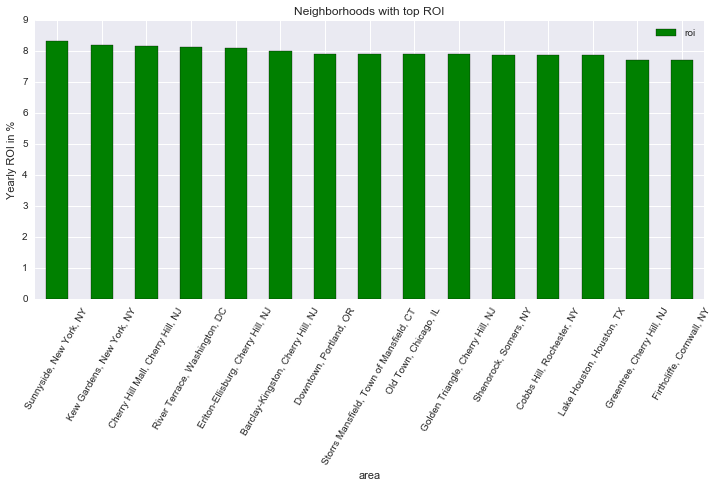

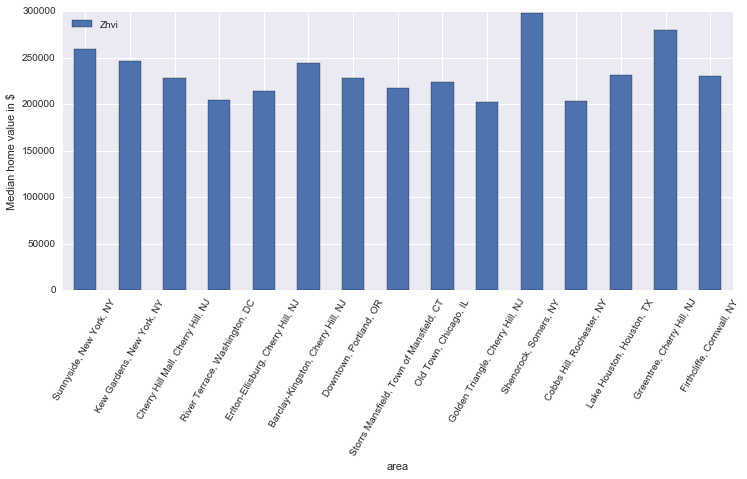

In [5]:
home_values_rents.sort_values(['roi'], ascending=[False], inplace=True)
top_picks = home_values_rents.head(15).copy()

top_picks['area'] = top_picks['RegionName']+', '+top_picks['City']+', '+top_picks['State']

fig, axs = plt.subplots(1,1,figsize=(12,5))
top_picks.plot(ax=axs, x='area', y=['roi'], kind='bar', color='green')
axs.set_ylabel('Yearly ROI in %')
axs.set_xticklabels(axs.xaxis.get_majorticklabels(), rotation=60)
axs.set_title('Neighborhoods with top ROI')

fig, axs = plt.subplots(1,1,figsize=(12,5))
top_picks.plot(ax=axs, x='area', y=['Zhvi'], kind='bar')
axs.set_ylabel('Median home value in $')
a = axs.set_xticklabels(axs.xaxis.get_majorticklabels(), rotation=60)


## Considering forcasted capital appreciation in addition to ROI

In addition to rental income, we like to consider the capital appreciation predicted in the next year to determine the overal return in the first year. ForecastYoY for "neighborhoods" are not available; so approximating it to be same as that of the respective City

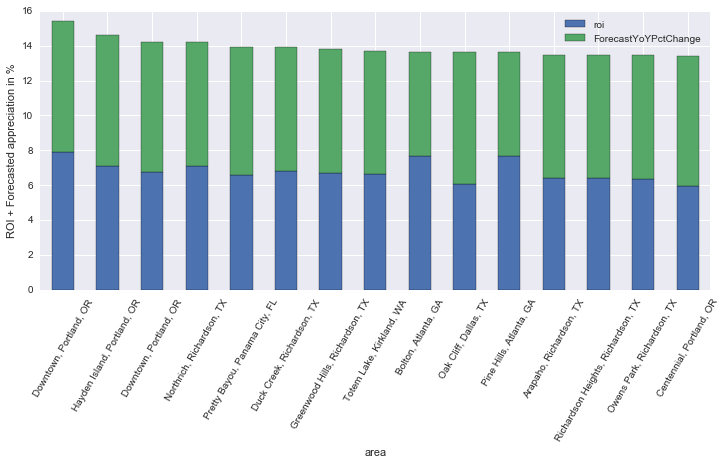

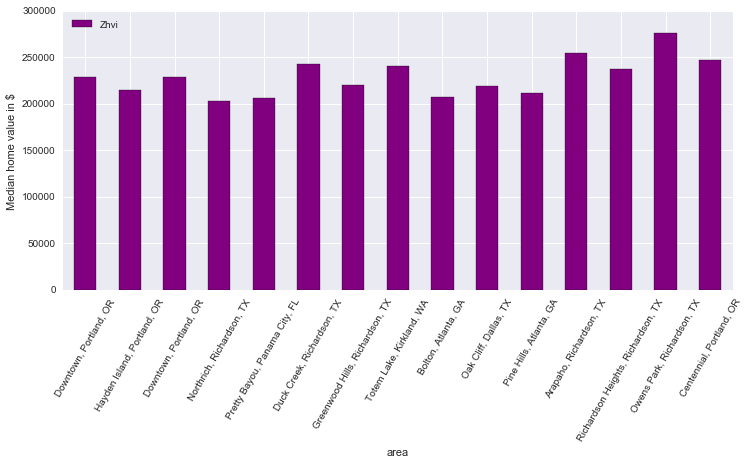

In [11]:
cap_appr = pd.read_csv('./data/AllRegionsForePublic.csv')
cap_appr = cap_appr[cap_appr['Region']=='City']
cap_appr.rename(columns={'CityName':'City'}, inplace=True)

cap_appr = cap_appr[['City','State','ForecastYoYPctChange']]

overall_data = pd.merge(home_values_rents, cap_appr, how='inner', on=['City','State'])
overall_data['roi_plus_appr'] = overall_data['roi']+overall_data['ForecastYoYPctChange']
overall_data.sort_values(['roi_plus_appr'], ascending=False, inplace=True)

top_picks = overall_data.head(15).copy()
top_picks['area'] = top_picks['RegionName']+', '+top_picks['City']+', '+top_picks['State']

fig, axs = plt.subplots(1,1,figsize=(12,5))
top_picks.plot(ax=axs, x='area', y=['roi','ForecastYoYPctChange'], stacked=True, kind='bar')
axs.set_ylabel('ROI + Forecasted appreciation in %')
a = axs.set_xticklabels(axs.xaxis.get_majorticklabels(), rotation=60)

fig, axs = plt.subplots(1,1,figsize=(12,5))
top_picks.plot(ax=axs, x='area', y=['Zhvi'], kind='bar', color='purple')
axs.set_ylabel('Median home value in $')
a = axs.set_xticklabels(axs.xaxis.get_majorticklabels(), rotation=60)